# Generación de gráficos

In [160]:
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
import tensorflow as tf
import datetime as dt
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [81]:
data_path = r'/data/dibanez/tesis/data_preprocesada/2.llenada/'

In [9]:
!ls {data_path}

llenado_Arequipa_UNSA_CIGS_agg_day_hour.csv
llenado_Arequipa_UNSA_HIT_agg_day_hour.csv
llenado_Arequipa_UNSA_PERC_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_CIGS_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_HIT_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_PERC_agg_day_hour.csv
llenado_Juliaca_UNAJ_CIGS_agg_day_hour.csv
llenado_Juliaca_UNAJ_HIT_agg_day_hour.csv
llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv
llenado_Lima_PUCP_CIGS_agg_day_hour.csv
llenado_Lima_PUCP_HIT_agg_day_hour.csv
llenado_Lima_PUCP_PERC_agg_day_hour.csv
llenado_Tacna_UNJBG_CIGS_agg_day_hour.csv
llenado_Tacna_UNJBG_HIT_agg_day_hour.csv
llenado_Tacna_UNJBG_PERC_agg_day_hour.csv


In [7]:
def print_df(df):
  print(df.shape)
  return df.head()


# Gráficos Chachapoyas

### Lectura de datos

In [61]:
data_file = data_path+'llenado_Chachapoyas_UNTRM_HIT_agg_day_hour.csv'
model_path = 'saved_models/lstm__Chachapoyas_HIT'
model = 'lstm'
technology = 'HIT'
ubicacion = 'Chachapoyas'
df_columns = ['Pac', 'Tmod']
fecha_ini = '2021-02-01'
fecha_fin = '2021-10-31'

In [13]:
df = pd.read_csv(data_file, parse_dates=True)
df.Fecha = pd.to_datetime(df.Fecha)
df=df.reset_index()
print_df(df)

(3145, 10)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc
0,0,2021-01-19 07:00:00,NaN,15.481038,126.680377,280.261225,0.663656,169.232893,127.25,188.702179
1,1,2021-01-19 08:00:00,NaN,21.373603,243.603396,286.352633,1.309358,352.285000,259.25,376.508333
2,2,2021-01-19 09:00:00,NaN,27.428326,326.799399,284.905883,1.737817,468.926667,488.50,495.450000
3,3,2021-01-19 10:00:00,NaN,35.033718,519.406319,284.755117,2.515042,682.881667,610.75,714.733333
4,4,2021-01-19 11:00:00,NaN,38.094180,621.082664,284.442400,2.985145,813.890000,434.75,850.175000


In [60]:
print(df.Fecha.min())
print(df.Fecha.max())

2021-01-19 07:00:00
2021-10-31 16:00:00


In [23]:
df.isna().sum()/len(df)

index          0.0
Fecha          0.0
Tamb           1.0
Tmod           0.0
Irradiancia    0.0
Vdc            0.0
Idc            0.0
Paparente      0.0
Pac            0.0
Pdc            0.0
Fecha_cod      0.0
dtype: float64

### Preprocesamiento

In [18]:
start = df.iloc[0]['Fecha']

In [20]:
df['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df))
# df.head(13)

In [22]:
series_raw = TimeSeries.from_dataframe(df, 'Fecha_cod', ['Pac','Tmod'])#,'Irradiancia'])#, freq='H')


In [25]:
col_obj = 'Pac'

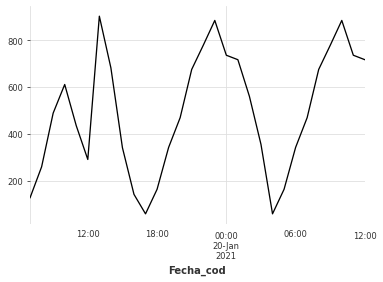

In [28]:
series_raw[0:30][col_obj].plot()

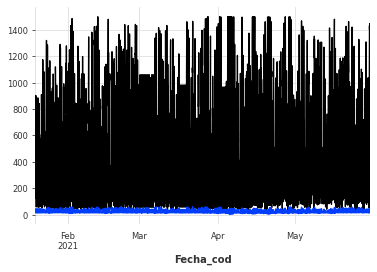

In [29]:
series_raw.plot()

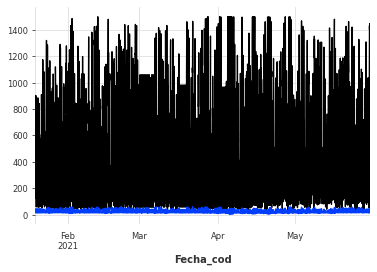

In [36]:
# TODO
filler = MissingValuesFiller()
series = filler.transform(series_raw, method='linear')
series.plot()

In [42]:
(series.values() != series_raw.values()).sum()

0

## Predicción LSTM

In [46]:
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 11, 50)            10600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 11)                121       
Total params: 13,161
Trainable params: 13,161
Non-trainable params: 0
_________________________________________________________________


In [49]:
df_f = df.set_index('Fecha')
print_df(df_f)

(3145, 10)


,index,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
Fecha,,,,,,,,,,
2021-01-19 07:00:00,0,NaN,15.481038,126.680377,280.261225,0.663656,169.232893,127.25,188.702179,2021-01-19 07:00:00
2021-01-19 08:00:00,1,NaN,21.373603,243.603396,286.352633,1.309358,352.285000,259.25,376.508333,2021-01-19 08:00:00
2021-01-19 09:00:00,2,NaN,27.428326,326.799399,284.905883,1.737817,468.926667,488.50,495.450000,2021-01-19 09:00:00
2021-01-19 10:00:00,3,NaN,35.033718,519.406319,284.755117,2.515042,682.881667,610.75,714.733333,2021-01-19 10:00:00
2021-01-19 11:00:00,4,NaN,38.094180,621.082664,284.442400,2.985145,813.890000,434.75,850.175000,2021-01-19 11:00:00


In [73]:
df_f["2021-01-20"][df_columns].values

array([[ 58.25968552,  11.96111905],
       [163.12595127,  15.48103781],
       [341.9530303 ,  21.37360297],
       [469.10909091,  27.42832607],
       [675.05454545,  35.03371835],
       [778.13939394,  38.09417994],
       [884.33787879,  43.94124555],
       [735.65606061,  37.7255226 ],
       [716.6       ,  34.07790476],
       [559.89242424,  32.34567958],
       [354.99848485,  26.03758612]])

In [125]:
df_t = df_f[fecha_ini: fecha_fin][df_columns]
df_t['Fecha'] = df_t.index
df_t['Date'] = df_t.index.date
df_t

,Pac,Tmod,Fecha,Date
Fecha,,,,
2021-02-01 06:00:00,45.714286,11.801333,2021-02-01 06:00:00,2021-02-01
2021-02-01 07:00:00,129.616667,15.322333,2021-02-01 07:00:00,2021-02-01
2021-02-01 08:00:00,291.050000,21.514167,2021-02-01 08:00:00,2021-02-01
2021-02-01 09:00:00,658.066667,34.237000,2021-02-01 09:00:00,2021-02-01
2021-02-01 10:00:00,674.716667,35.393051,2021-02-01 10:00:00,2021-02-01
...,...,...,...,...
2021-10-31 12:00:00,1402.250000,45.145667,2021-10-31 12:00:00,2021-10-31
2021-10-31 13:00:00,1448.083333,42.948500,2021-10-31 13:00:00,2021-10-31
2021-10-31 14:00:00,1115.516667,38.936667,2021-10-31 14:00:00,2021-10-31


In [156]:
series_t = None
for dtime in list(df_t.Date.drop_duplicates())[:-1]:
#     print(dtime)
    x_input = df_t[str(dtime)][df_columns].values.reshape((1,11,2)) 
    pred = new_model.predict(x_input)
    if series_t is None:
        print(pred)
        series_t = pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index)
    else :
        series_t = series_t.append(pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index))
series_t

[[ 137.41858   96.56515  291.68558  603.0112   850.6446   966.0812
  1003.6733   974.0643   896.6647   688.51135  390.12112]]


Fecha
2021-02-02 06:00:00    137.418579
2021-02-02 07:00:00     96.565147
2021-02-02 08:00:00    291.685577
2021-02-02 09:00:00    603.011230
2021-02-02 10:00:00    850.644592
                          ...    
2021-10-31 12:00:00    983.894897
2021-10-31 13:00:00    911.560486
2021-10-31 14:00:00    739.276917
2021-10-31 15:00:00    444.846588
2021-10-31 16:00:00    195.407455
Length: 2992, dtype: float32

In [157]:
df_t['pred']= series_t

In [292]:
image_dir =  f'graficos/{model_path.split("/")[-1]}'
image_dir

'graficos/lstm__Chachapoyas_HIT'

In [289]:
!mkdir graficos

mkdir: cannot create directory ‘graficos’: File exists


In [291]:
!mkdir {image_dir}

mkdir: cannot create directory ‘graficos/lstm__Chachapoyas_HIT’: File exists


In [298]:
ls = []
for dtime in list(df_t.Date.drop_duplicates())[4:]:
    
    #previous day fig
#     print(dtime)
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
    pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name = f'graficos/{model_path.split("/")[-1]}/{model_path.split("/")[-1]}-{str(dtime)}.png'
    plt.savefig(name,bbox_inches='tight')
#     plt.savefig('images/p3.png',bbox_inches='tight')
    plt.clf()
    
    #current day fig
    
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
#     pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name_current_day = f'graficos/{model_path.split("/")[-1]}/current_day_{model_path.split("/")[-1]}-{str(dtime)}.png'
    
    plt.savefig(name_current_day,bbox_inches='tight')
    plt.clf()

    ls.append((str(dtime), name, name_current_day,\
               math.sqrt(mean_squared_error(pac, pred)),\
               math.sqrt(mean_squared_error(pac_1, pred_1))))
#     break
print(ls[:2])
len(ls)


[('2021-02-05', 'graficos/lstm__Chachapoyas_HIT/lstm__Chachapoyas_HIT-2021-02-05.png', 'graficos/lstm__Chachapoyas_HIT/current_day_lstm__Chachapoyas_HIT-2021-02-05.png', 165.90968013436589, 151.9924045823211), ('2021-02-06', 'graficos/lstm__Chachapoyas_HIT/lstm__Chachapoyas_HIT-2021-02-06.png', 'graficos/lstm__Chachapoyas_HIT/current_day_lstm__Chachapoyas_HIT-2021-02-06.png', 275.0997871296916, 165.90968013436589)]


269

<Figure size 432x288 with 0 Axes>

In [148]:
# list(df_t.Date.drop_duplicates())[1:-1]

In [309]:
# ls

In [310]:
ml_model_id = 4
metric_name = 'RMSE'
date = ''
value = ''
previous_value = ''
imag_path = ''

In [311]:
"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ('f', 'f', 'f', 'f', 'f', 'f','f');
"""

"\nINSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)\nVALUES ('f', 'f', 'f', 'f', 'f', 'f','f');\n"

In [312]:
stri = ''
for l in ls:
    date = l[0]
    imag_path=l[1]
    current_img_path = l[2]
    value=l[3]
    previous_value=l[4]
    stri +=f"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ({ml_model_id}, '{metric_name}', '{date}', {value}, {previous_value}, '{imag_path}','{current_img_path}');
"""

In [313]:
len(stri.split('\n\n'))

269

In [315]:
stri_chachapoyas_cnn = stri

In [317]:
#Imprimir comando INSERT INTO

# print(stri_chachapoyas_cnn)



## Predicción CNN

In [318]:
model_path = 'saved_models/1dcnn_Chachapoyas_HIT'
model = '1dcnn'

In [319]:
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [320]:
df_f = df.set_index('Fecha')
print_df(df_f)

(3145, 10)


,index,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
Fecha,,,,,,,,,,
2021-01-19 07:00:00,0,NaN,15.481038,126.680377,280.261225,0.663656,169.232893,127.25,188.702179,2021-01-19 07:00:00
2021-01-19 08:00:00,1,NaN,21.373603,243.603396,286.352633,1.309358,352.285000,259.25,376.508333,2021-01-19 08:00:00
2021-01-19 09:00:00,2,NaN,27.428326,326.799399,284.905883,1.737817,468.926667,488.50,495.450000,2021-01-19 09:00:00
2021-01-19 10:00:00,3,NaN,35.033718,519.406319,284.755117,2.515042,682.881667,610.75,714.733333,2021-01-19 10:00:00
2021-01-19 11:00:00,4,NaN,38.094180,621.082664,284.442400,2.985145,813.890000,434.75,850.175000,2021-01-19 11:00:00


In [321]:
df_f["2021-01-20"][df_columns].values

array([[ 58.25968552,  11.96111905],
       [163.12595127,  15.48103781],
       [341.9530303 ,  21.37360297],
       [469.10909091,  27.42832607],
       [675.05454545,  35.03371835],
       [778.13939394,  38.09417994],
       [884.33787879,  43.94124555],
       [735.65606061,  37.7255226 ],
       [716.6       ,  34.07790476],
       [559.89242424,  32.34567958],
       [354.99848485,  26.03758612]])

In [322]:
df_t = df_f[fecha_ini: fecha_fin][df_columns]
df_t['Fecha'] = df_t.index
df_t['Date'] = df_t.index.date
df_t

,Pac,Tmod,Fecha,Date
Fecha,,,,
2021-02-01 06:00:00,45.714286,11.801333,2021-02-01 06:00:00,2021-02-01
2021-02-01 07:00:00,129.616667,15.322333,2021-02-01 07:00:00,2021-02-01
2021-02-01 08:00:00,291.050000,21.514167,2021-02-01 08:00:00,2021-02-01
2021-02-01 09:00:00,658.066667,34.237000,2021-02-01 09:00:00,2021-02-01
2021-02-01 10:00:00,674.716667,35.393051,2021-02-01 10:00:00,2021-02-01
...,...,...,...,...
2021-10-31 12:00:00,1402.250000,45.145667,2021-10-31 12:00:00,2021-10-31
2021-10-31 13:00:00,1448.083333,42.948500,2021-10-31 13:00:00,2021-10-31
2021-10-31 14:00:00,1115.516667,38.936667,2021-10-31 14:00:00,2021-10-31


In [323]:
series_t = None
for dtime in list(df_t.Date.drop_duplicates())[:-1]:
#     print(dtime)
    x_input = df_t[str(dtime)][df_columns].values.reshape((1,11,2)) 
    pred = new_model.predict(x_input)
    if series_t is None:
        print(pred)
        series_t = pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index)
    else :
        series_t = series_t.append(pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index))
series_t

[[205.11786 203.83694 467.84912 656.6301  805.589   918.4612  930.1508
  952.4798  826.78064 672.7269  517.5668 ]]


Fecha
2021-02-02 06:00:00    205.117859
2021-02-02 07:00:00    203.836945
2021-02-02 08:00:00    467.849121
2021-02-02 09:00:00    656.630127
2021-02-02 10:00:00    805.588989
                          ...    
2021-10-31 12:00:00    895.512268
2021-10-31 13:00:00    869.339233
2021-10-31 14:00:00    735.284241
2021-10-31 15:00:00    452.882812
2021-10-31 16:00:00    136.648438
Length: 2992, dtype: float32

In [324]:
df_t['pred']= series_t

In [325]:
image_dir =  f'graficos/{model_path.split("/")[-1]}'
image_dir

'graficos/1dcnn_Chachapoyas_HIT'

In [326]:
!mkdir graficos

mkdir: cannot create directory ‘graficos’: File exists


In [328]:
!mkdir {image_dir}

mkdir: cannot create directory ‘graficos/1dcnn_Chachapoyas_HIT’: File exists


In [329]:
ls = []
for dtime in list(df_t.Date.drop_duplicates())[4:]:
    
    #previous day fig
#     print(dtime)
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
    pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name = f'graficos/{model_path.split("/")[-1]}/{model_path.split("/")[-1]}-{str(dtime)}.png'
    plt.savefig(name,bbox_inches='tight')
#     plt.savefig('images/p3.png',bbox_inches='tight')
    plt.clf()
    
    #current day fig
    
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
#     pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name_current_day = f'graficos/{model_path.split("/")[-1]}/current_day_{model_path.split("/")[-1]}-{str(dtime)}.png'
    
    plt.savefig(name_current_day,bbox_inches='tight')
    plt.clf()

    ls.append((str(dtime), name, name_current_day,\
               math.sqrt(mean_squared_error(pac, pred)),\
               math.sqrt(mean_squared_error(pac_1, pred_1))))
#     break
print(ls[:2])
len(ls)


[('2021-02-05', 'graficos/1dcnn_Chachapoyas_HIT/1dcnn_Chachapoyas_HIT-2021-02-05.png', 'graficos/1dcnn_Chachapoyas_HIT/current_day_1dcnn_Chachapoyas_HIT-2021-02-05.png', 112.53677263071994, 113.30160103878855), ('2021-02-06', 'graficos/1dcnn_Chachapoyas_HIT/1dcnn_Chachapoyas_HIT-2021-02-06.png', 'graficos/1dcnn_Chachapoyas_HIT/current_day_1dcnn_Chachapoyas_HIT-2021-02-06.png', 104.08115971113446, 112.53677263071994)]


269

<Figure size 432x288 with 0 Axes>

In [148]:
# list(df_t.Date.drop_duplicates())[1:-1]

In [309]:
# ls

In [330]:
ml_model_id = 3
metric_name = 'RMSE'
date = ''
value = ''
previous_value = ''
imag_path = ''
current_img_path = ''

In [331]:
"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ('f', 'f', 'f', 'f', 'f', 'f','f');
"""

"\nINSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)\nVALUES ('f', 'f', 'f', 'f', 'f', 'f','f');\n"

In [332]:
stri = ''
for l in ls:
    date = l[0]
    imag_path=l[1]
    current_img_path = l[2]
    value=l[3]
    previous_value=l[4]
    stri +=f"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ({ml_model_id}, '{metric_name}', '{date}', {value}, {previous_value}, '{imag_path}','{current_img_path}');
"""

In [333]:
len(stri.split('\n\n'))

269

In [334]:
stri_chachapoyas_actual_cnn = stri

In [336]:
#Imprimir comando INSERT INTO

# print(stri_chachapoyas_actual_cnn)




# Gráficos Lima

In [337]:
!ls {data_path}

llenado_Arequipa_UNSA_CIGS_agg_day_hour.csv
llenado_Arequipa_UNSA_HIT_agg_day_hour.csv
llenado_Arequipa_UNSA_PERC_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_CIGS_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_HIT_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_PERC_agg_day_hour.csv
llenado_Juliaca_UNAJ_CIGS_agg_day_hour.csv
llenado_Juliaca_UNAJ_HIT_agg_day_hour.csv
llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv
llenado_Lima_PUCP_CIGS_agg_day_hour.csv
llenado_Lima_PUCP_HIT_agg_day_hour.csv
llenado_Lima_PUCP_PERC_agg_day_hour.csv
llenado_Tacna_UNJBG_CIGS_agg_day_hour.csv
llenado_Tacna_UNJBG_HIT_agg_day_hour.csv
llenado_Tacna_UNJBG_PERC_agg_day_hour.csv


### Lectura de datos

In [381]:
data_file = data_path+'llenado_Lima_PUCP_HIT_agg_day_hour.csv'
model_path = 'saved_models/1dcnn_Lima_HIT'
model = '1dcnn'
technology = 'HIT'
ubicacion = 'Lima'
df_columns = ['Pac', 'Tamb']
fecha_ini = '2021-02-01'
fecha_fin = '2021-10-31'

In [382]:
df = pd.read_csv(data_file, parse_dates=True)
df.Fecha = pd.to_datetime(df.Fecha)
df=df.reset_index()
print_df(df)

(7029, 10)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc
0,0,2020-02-01 06:00:00,22.026791,NaN,27.115116,233.741749,0.188250,60.621361,66.380581,75.573104
1,1,2020-02-01 07:00:00,21.722877,NaN,111.537495,255.771884,0.569894,151.159816,169.414987,212.997443
2,2,2020-02-01 08:00:00,22.832072,NaN,416.345874,261.371965,1.555141,416.224706,407.368163,492.720706
3,3,2020-02-01 09:00:00,23.769869,NaN,557.163245,259.826929,2.571577,683.643427,696.240826,790.159728
4,4,2020-02-01 10:00:00,25.171561,NaN,843.467267,258.953148,3.368592,893.302314,946.676771,1034.689049


In [383]:
print(df.Fecha.min())
print(df.Fecha.max())

2020-02-01 06:00:00
2021-10-31 16:00:00


In [384]:
df.isna().sum()/len(df)

index          0.000000
Fecha          0.000000
Tamb           0.000000
Tmod           0.524257
Irradiancia    0.004410
Vdc            0.004410
Idc            0.004410
Paparente      0.004410
Pac            0.021909
Pdc            0.013089
dtype: float64

### Preprocesamiento

In [385]:
start = df.iloc[0]['Fecha']

In [386]:
df['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df))
# df.head(13)

In [387]:
series_raw = TimeSeries.from_dataframe(df, 'Fecha_cod', df_columns)#,'Irradiancia'])#, freq='H')


In [388]:
col_obj = 'Pac'

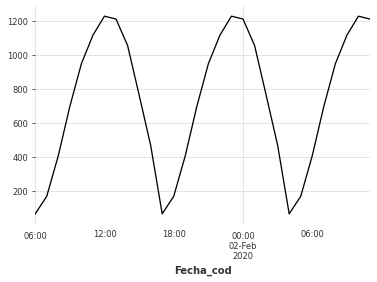

In [389]:
series_raw[0:30][col_obj].plot()

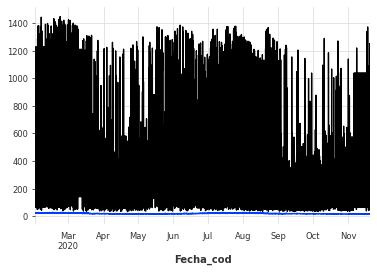

In [390]:
series_raw.plot()

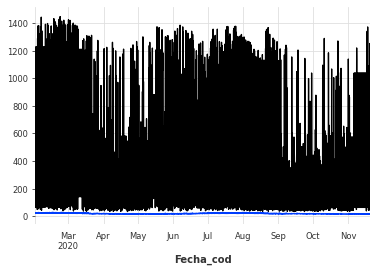

In [391]:
# TODO
filler = MissingValuesFiller()
series = filler.transform(series_raw, method='linear')
series.plot()

In [392]:
(series.values() != series_raw.values()).sum()

154

In [393]:
len(series)

7029

In [401]:
new_data = pd.DataFrame(series.values(), columns=df_columns)
new_data

,Pac,Tamb
0,66.380581,22.026791
1,169.414987,21.722877
2,407.368163,22.832072
3,696.240826,23.769869
4,946.676771,25.171561
...,...,...
7024,1108.416667,16.952497
7025,785.083333,17.084003
7026,495.400000,16.986584
7027,303.366667,16.722459


In [402]:
df[df_columns] = new_data
df.head()

,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
0,0,2020-02-01 06:00:00,22.026791,NaN,27.115116,233.741749,0.188250,60.621361,66.380581,75.573104,2020-02-01 06:00:00
1,1,2020-02-01 07:00:00,21.722877,NaN,111.537495,255.771884,0.569894,151.159816,169.414987,212.997443,2020-02-01 07:00:00
2,2,2020-02-01 08:00:00,22.832072,NaN,416.345874,261.371965,1.555141,416.224706,407.368163,492.720706,2020-02-01 08:00:00
3,3,2020-02-01 09:00:00,23.769869,NaN,557.163245,259.826929,2.571577,683.643427,696.240826,790.159728,2020-02-01 09:00:00
4,4,2020-02-01 10:00:00,25.171561,NaN,843.467267,258.953148,3.368592,893.302314,946.676771,1034.689049,2020-02-01 10:00:00


In [404]:
df.isna().sum()

index             0
Fecha             0
Tamb              0
Tmod           3685
Irradiancia      31
Vdc              31
Idc              31
Paparente        31
Pac               0
Pdc              92
Fecha_cod         0
dtype: int64

## Predicción CNN

In [405]:
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_6 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [406]:
df_f = df.set_index('Fecha')
print_df(df_f)

(7029, 10)


,index,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
Fecha,,,,,,,,,,
2020-02-01 06:00:00,0,22.026791,NaN,27.115116,233.741749,0.188250,60.621361,66.380581,75.573104,2020-02-01 06:00:00
2020-02-01 07:00:00,1,21.722877,NaN,111.537495,255.771884,0.569894,151.159816,169.414987,212.997443,2020-02-01 07:00:00
2020-02-01 08:00:00,2,22.832072,NaN,416.345874,261.371965,1.555141,416.224706,407.368163,492.720706,2020-02-01 08:00:00
2020-02-01 09:00:00,3,23.769869,NaN,557.163245,259.826929,2.571577,683.643427,696.240826,790.159728,2020-02-01 09:00:00
2020-02-01 10:00:00,4,25.171561,NaN,843.467267,258.953148,3.368592,893.302314,946.676771,1034.689049,2020-02-01 10:00:00


In [407]:
df_f["2021-01-20"][df_columns].values

array([[  72.38685109,   18.96233802],
       [ 127.39773128,   19.0178576 ],
       [ 270.75      ,   19.37846786],
       [ 646.58333333,   19.99352832],
       [ 871.61666667,   20.68430881],
       [1142.18333333,   21.07994472],
       [1141.41373222,   21.25255995],
       [1070.1052332 ,   21.62429523],
       [1024.86524289,   21.79883812],
       [ 536.73333333,   21.48475935],
       [ 431.85      ,   21.50942573]])

In [408]:
df_t = df_f[fecha_ini: fecha_fin][df_columns]
df_t['Fecha'] = df_t.index
df_t['Date'] = df_t.index.date
df_t

,Pac,Tamb,Fecha,Date
Fecha,,,,
2021-02-01 06:00:00,83.085714,19.024617,2021-02-01 06:00:00,2021-02-01
2021-02-01 07:00:00,246.533333,19.804029,2021-02-01 07:00:00,2021-02-01
2021-02-01 08:00:00,576.316667,21.077390,2021-02-01 08:00:00,2021-02-01
2021-02-01 09:00:00,907.816667,22.529712,2021-02-01 09:00:00,2021-02-01
2021-02-01 10:00:00,1159.900000,22.675667,2021-02-01 10:00:00,2021-02-01
...,...,...,...,...
2021-10-31 12:00:00,1108.416667,16.952497,2021-10-31 12:00:00,2021-10-31
2021-10-31 13:00:00,785.083333,17.084003,2021-10-31 13:00:00,2021-10-31
2021-10-31 14:00:00,495.400000,16.986584,2021-10-31 14:00:00,2021-10-31


In [409]:
series_t = None
for dtime in list(df_t.Date.drop_duplicates())[:-1]:
#     print(dtime)
    x_input = df_t[str(dtime)][df_columns].values.reshape((1,11,2)) 
    pred = new_model.predict(x_input)
    if series_t is None:
        print(pred)
        series_t = pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index)
    else :
        series_t = series_t.append(pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index))
series_t

[[  69.6706   153.30745  376.8964   670.9531   922.7116  1144.0259
  1183.3802  1103.7953   869.96906  620.33905  340.33813]]


Fecha
2021-02-02 06:00:00     69.670601
2021-02-02 07:00:00    153.307449
2021-02-02 08:00:00    376.896393
2021-02-02 09:00:00    670.953125
2021-02-02 10:00:00    922.711609
                          ...    
2021-10-31 12:00:00    823.908752
2021-10-31 13:00:00    746.706360
2021-10-31 14:00:00    612.094299
2021-10-31 15:00:00    406.399506
2021-10-31 16:00:00    205.451599
Length: 2992, dtype: float32

In [410]:
df_t['pred']= series_t

In [411]:
image_dir =  f'graficos/{model_path.split("/")[-1]}'
image_dir

'graficos/1dcnn_Lima_HIT'

In [412]:
!mkdir graficos

mkdir: cannot create directory ‘graficos’: File exists


In [413]:
!mkdir {image_dir}

mkdir: cannot create directory ‘graficos/1dcnn_Lima_HIT’: File exists


In [415]:
%%time
ls = []
for dtime in list(df_t.Date.drop_duplicates())[4:]:
    
    #previous day fig
#     print(dtime)
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
    pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name = f'graficos/{model_path.split("/")[-1]}/{model_path.split("/")[-1]}-{str(dtime)}.png'
    plt.savefig(name,bbox_inches='tight')
#     plt.savefig('images/p3.png',bbox_inches='tight')
    plt.clf()
    
    #current day fig
    
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
#     pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name_current_day = f'graficos/{model_path.split("/")[-1]}/current_day_{model_path.split("/")[-1]}-{str(dtime)}.png'
    
    plt.savefig(name_current_day,bbox_inches='tight')
    plt.clf()

    ls.append((str(dtime), name, name_current_day,\
               math.sqrt(mean_squared_error(pac, pred)),\
               math.sqrt(mean_squared_error(pac_1, pred_1))))
#     break
print(ls[:2])
len(ls)


[('2021-02-05', 'graficos/1dcnn_Lima_HIT/1dcnn_Lima_HIT-2021-02-05.png', 'graficos/1dcnn_Lima_HIT/current_day_1dcnn_Lima_HIT-2021-02-05.png', 156.35502628494254, 129.55563495286825), ('2021-02-06', 'graficos/1dcnn_Lima_HIT/1dcnn_Lima_HIT-2021-02-06.png', 'graficos/1dcnn_Lima_HIT/current_day_1dcnn_Lima_HIT-2021-02-06.png', 164.16475802127312, 156.35502628494254)]
CPU times: user 2min 7s, sys: 0 ns, total: 2min 7s
Wall time: 2min 6s


269

<Figure size 432x288 with 0 Axes>

In [416]:
# list(df_t.Date.drop_duplicates())[1:-1]

In [417]:
# ls

In [418]:
ml_model_id = 1
metric_name = 'RMSE'
date = ''
value = ''
previous_value = ''
imag_path = ''

In [419]:
"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ('f', 'f', 'f', 'f', 'f', 'f','f');
"""

"\nINSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)\nVALUES ('f', 'f', 'f', 'f', 'f', 'f','f');\n"

In [420]:
stri = ''
for l in ls:
    date = l[0]
    imag_path=l[1]
    current_img_path = l[2]
    value=l[3]
    previous_value=l[4]
    stri +=f"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ({ml_model_id}, '{metric_name}', '{date}', {value}, {previous_value}, '{imag_path}','{current_img_path}');
"""

In [421]:
len(stri.split('\n\n'))

269

In [423]:
stri_lima_cnn = stri

In [425]:
#Imprimir comando INSERT INTO

# print(stri_lima_cnn)



## Predicción LSTM

In [447]:
model_path = 'saved_models/lstm_Lima_HIT'
model = 'lstm'

In [449]:
#Mismo que cnn
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_6 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [446]:
# new_model.trainable_weights[0] == tf.keras.models.load_model('saved_models/lstm_Lima_HIT').trainable_weights[0]

In [320]:
df_f = df.set_index('Fecha')
print_df(df_f)

(3145, 10)


,index,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
Fecha,,,,,,,,,,
2021-01-19 07:00:00,0,NaN,15.481038,126.680377,280.261225,0.663656,169.232893,127.25,188.702179,2021-01-19 07:00:00
2021-01-19 08:00:00,1,NaN,21.373603,243.603396,286.352633,1.309358,352.285000,259.25,376.508333,2021-01-19 08:00:00
2021-01-19 09:00:00,2,NaN,27.428326,326.799399,284.905883,1.737817,468.926667,488.50,495.450000,2021-01-19 09:00:00
2021-01-19 10:00:00,3,NaN,35.033718,519.406319,284.755117,2.515042,682.881667,610.75,714.733333,2021-01-19 10:00:00
2021-01-19 11:00:00,4,NaN,38.094180,621.082664,284.442400,2.985145,813.890000,434.75,850.175000,2021-01-19 11:00:00


In [321]:
df_f["2021-01-20"][df_columns].values

array([[ 58.25968552,  11.96111905],
       [163.12595127,  15.48103781],
       [341.9530303 ,  21.37360297],
       [469.10909091,  27.42832607],
       [675.05454545,  35.03371835],
       [778.13939394,  38.09417994],
       [884.33787879,  43.94124555],
       [735.65606061,  37.7255226 ],
       [716.6       ,  34.07790476],
       [559.89242424,  32.34567958],
       [354.99848485,  26.03758612]])

In [322]:
df_t = df_f[fecha_ini: fecha_fin][df_columns]
df_t['Fecha'] = df_t.index
df_t['Date'] = df_t.index.date
df_t

,Pac,Tmod,Fecha,Date
Fecha,,,,
2021-02-01 06:00:00,45.714286,11.801333,2021-02-01 06:00:00,2021-02-01
2021-02-01 07:00:00,129.616667,15.322333,2021-02-01 07:00:00,2021-02-01
2021-02-01 08:00:00,291.050000,21.514167,2021-02-01 08:00:00,2021-02-01
2021-02-01 09:00:00,658.066667,34.237000,2021-02-01 09:00:00,2021-02-01
2021-02-01 10:00:00,674.716667,35.393051,2021-02-01 10:00:00,2021-02-01
...,...,...,...,...
2021-10-31 12:00:00,1402.250000,45.145667,2021-10-31 12:00:00,2021-10-31
2021-10-31 13:00:00,1448.083333,42.948500,2021-10-31 13:00:00,2021-10-31
2021-10-31 14:00:00,1115.516667,38.936667,2021-10-31 14:00:00,2021-10-31


In [323]:
series_t = None
for dtime in list(df_t.Date.drop_duplicates())[:-1]:
#     print(dtime)
    x_input = df_t[str(dtime)][df_columns].values.reshape((1,11,2)) 
    pred = new_model.predict(x_input)
    if series_t is None:
        print(pred)
        series_t = pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index)
    else :
        series_t = series_t.append(pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index))
series_t

[[205.11786 203.83694 467.84912 656.6301  805.589   918.4612  930.1508
  952.4798  826.78064 672.7269  517.5668 ]]


Fecha
2021-02-02 06:00:00    205.117859
2021-02-02 07:00:00    203.836945
2021-02-02 08:00:00    467.849121
2021-02-02 09:00:00    656.630127
2021-02-02 10:00:00    805.588989
                          ...    
2021-10-31 12:00:00    895.512268
2021-10-31 13:00:00    869.339233
2021-10-31 14:00:00    735.284241
2021-10-31 15:00:00    452.882812
2021-10-31 16:00:00    136.648438
Length: 2992, dtype: float32

In [324]:
df_t['pred']= series_t

In [325]:
image_dir =  f'graficos/{model_path.split("/")[-1]}'
image_dir

'graficos/1dcnn_Chachapoyas_HIT'

In [326]:
!mkdir graficos

mkdir: cannot create directory ‘graficos’: File exists


In [328]:
!mkdir {image_dir}

mkdir: cannot create directory ‘graficos/1dcnn_Chachapoyas_HIT’: File exists


In [329]:
ls = []
for dtime in list(df_t.Date.drop_duplicates())[4:]:
    
    #previous day fig
#     print(dtime)
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
    pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name = f'graficos/{model_path.split("/")[-1]}/{model_path.split("/")[-1]}-{str(dtime)}.png'
    plt.savefig(name,bbox_inches='tight')
#     plt.savefig('images/p3.png',bbox_inches='tight')
    plt.clf()
    
    #current day fig
    
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
#     pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name_current_day = f'graficos/{model_path.split("/")[-1]}/current_day_{model_path.split("/")[-1]}-{str(dtime)}.png'
    
    plt.savefig(name_current_day,bbox_inches='tight')
    plt.clf()

    ls.append((str(dtime), name, name_current_day,\
               math.sqrt(mean_squared_error(pac, pred)),\
               math.sqrt(mean_squared_error(pac_1, pred_1))))
#     break
print(ls[:2])
len(ls)


[('2021-02-05', 'graficos/1dcnn_Chachapoyas_HIT/1dcnn_Chachapoyas_HIT-2021-02-05.png', 'graficos/1dcnn_Chachapoyas_HIT/current_day_1dcnn_Chachapoyas_HIT-2021-02-05.png', 112.53677263071994, 113.30160103878855), ('2021-02-06', 'graficos/1dcnn_Chachapoyas_HIT/1dcnn_Chachapoyas_HIT-2021-02-06.png', 'graficos/1dcnn_Chachapoyas_HIT/current_day_1dcnn_Chachapoyas_HIT-2021-02-06.png', 104.08115971113446, 112.53677263071994)]


269

<Figure size 432x288 with 0 Axes>

In [148]:
# list(df_t.Date.drop_duplicates())[1:-1]

In [309]:
# ls

In [330]:
ml_model_id = 3
metric_name = 'RMSE'
date = ''
value = ''
previous_value = ''
imag_path = ''
current_img_path = ''

In [331]:
"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ('f', 'f', 'f', 'f', 'f', 'f','f');
"""

"\nINSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)\nVALUES ('f', 'f', 'f', 'f', 'f', 'f','f');\n"

In [332]:
stri = ''
for l in ls:
    date = l[0]
    imag_path=l[1]
    current_img_path = l[2]
    value=l[3]
    previous_value=l[4]
    stri +=f"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ({ml_model_id}, '{metric_name}', '{date}', {value}, {previous_value}, '{imag_path}','{current_img_path}');
"""

In [333]:
len(stri.split('\n\n'))

269

In [334]:
# stri_chachapoyas_actual_cnn = stri

In [452]:
#Imprimir comando INSERT INTO
#Mismo que cnn
# print(stri_chachapoyas_actual_cnn)




# Gráficos Juliaca

## Datos HIT Transfered

In [453]:
!ls {data_path}

llenado_Arequipa_UNSA_CIGS_agg_day_hour.csv
llenado_Arequipa_UNSA_HIT_agg_day_hour.csv
llenado_Arequipa_UNSA_PERC_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_CIGS_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_HIT_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_PERC_agg_day_hour.csv
llenado_Juliaca_UNAJ_CIGS_agg_day_hour.csv
llenado_Juliaca_UNAJ_HIT_agg_day_hour.csv
llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv
llenado_Lima_PUCP_CIGS_agg_day_hour.csv
llenado_Lima_PUCP_HIT_agg_day_hour.csv
llenado_Lima_PUCP_PERC_agg_day_hour.csv
llenado_Tacna_UNJBG_CIGS_agg_day_hour.csv
llenado_Tacna_UNJBG_HIT_agg_day_hour.csv
llenado_Tacna_UNJBG_PERC_agg_day_hour.csv


### Lectura de datos

In [458]:
data_file = data_path+'llenado_Juliaca_UNAJ_HIT_agg_day_hour.csv'
model_path = 'saved_models/1dcnn_Chachapoyas_to_Juliaca_HIT'
model = '1dcnn'
technology = 'HIT'
ubicacion = 'ChachapoyasToJuliaca'
df_columns = ['Pac', 'Tmod']
fecha_ini = '2021-02-01'
fecha_fin = '2021-10-31'

In [509]:
data_file

'/data/dibanez/tesis/data_preprocesada/2.llenada/llenado_Juliaca_UNAJ_HIT_agg_day_hour.csv'

In [459]:
df = pd.read_csv(data_file, parse_dates=True)
df.Fecha = pd.to_datetime(df.Fecha)
df=df.reset_index()
print_df(df)

(2098, 10)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc
0,0,2021-04-24 09:00:00,NaN,34.972500,NaN,280.775139,4.749689,1280.711111,725.25,1335.512452
1,1,2021-04-24 10:00:00,NaN,35.085333,NaN,286.157139,4.822428,1329.452778,1422.00,1383.670669
2,2,2021-04-24 11:00:00,NaN,40.175500,NaN,292.318028,4.879322,1379.002778,1152.00,1433.825000
3,3,2021-04-24 12:00:00,NaN,44.957333,NaN,288.280642,4.392036,1229.313272,1463.75,1278.857407
4,4,2021-04-24 13:00:00,NaN,39.497586,NaN,282.816713,4.245637,1154.008380,1480.75,1203.392830


In [460]:
print(df.Fecha.min())
print(df.Fecha.max())

2021-04-24 09:00:00
2021-10-31 16:00:00


In [461]:
df.isna().sum()/len(df)

index          0.0
Fecha          0.0
Tamb           1.0
Tmod           0.0
Irradiancia    1.0
Vdc            0.0
Idc            0.0
Paparente      0.0
Pac            0.0
Pdc            0.0
dtype: float64

### Preprocesamiento

In [462]:
start = df.iloc[0]['Fecha']

In [463]:
df['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df))
# df.head(13)

In [464]:
series_raw = TimeSeries.from_dataframe(df, 'Fecha_cod', df_columns)#,'Irradiancia'])#, freq='H')


In [465]:
col_obj = 'Pac'

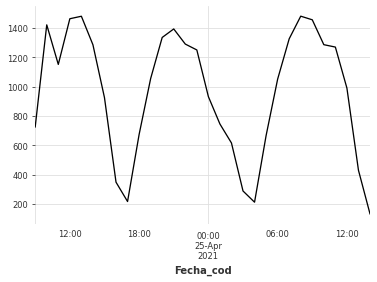

In [466]:
series_raw[0:30][col_obj].plot()

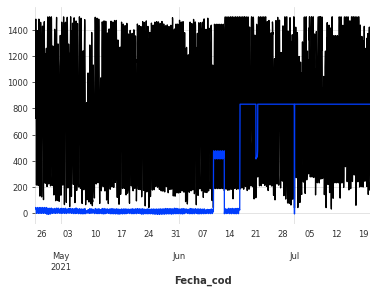

In [467]:
series_raw.plot()

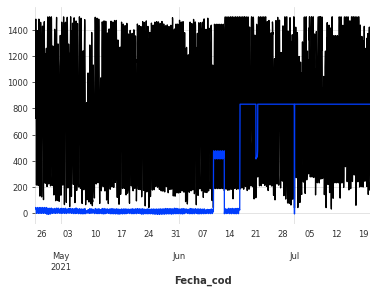

In [468]:
# TODO
filler = MissingValuesFiller()
series = filler.transform(series_raw, method='linear')
series.plot()

In [469]:
(series.values() != series_raw.values()).sum()

0

In [470]:
# len(series)

In [471]:
# new_data = pd.DataFrame(series.values(), columns=df_columns)
# new_data

In [472]:
# df[df_columns] = new_data
# df.head()

In [473]:
df.isna().sum()

index             0
Fecha             0
Tamb           2098
Tmod              0
Irradiancia    2098
Vdc               0
Idc               0
Paparente         0
Pac               0
Pdc               0
Fecha_cod         0
dtype: int64

## Predicción CNN

In [474]:
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,611
Non-trainable params: 320
_________________________________________________________________


In [475]:
df_f = df.set_index('Fecha')
print_df(df_f)

(2098, 10)


,index,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
Fecha,,,,,,,,,,
2021-04-24 09:00:00,0,NaN,34.972500,NaN,280.775139,4.749689,1280.711111,725.25,1335.512452,2021-04-24 09:00:00
2021-04-24 10:00:00,1,NaN,35.085333,NaN,286.157139,4.822428,1329.452778,1422.00,1383.670669,2021-04-24 10:00:00
2021-04-24 11:00:00,2,NaN,40.175500,NaN,292.318028,4.879322,1379.002778,1152.00,1433.825000,2021-04-24 11:00:00
2021-04-24 12:00:00,3,NaN,44.957333,NaN,288.280642,4.392036,1229.313272,1463.75,1278.857407,2021-04-24 12:00:00
2021-04-24 13:00:00,4,NaN,39.497586,NaN,282.816713,4.245637,1154.008380,1480.75,1203.392830,2021-04-24 13:00:00


In [478]:
df_f["2021-04-24"][df_columns].values

array([[ 725.25      ,   34.9725    ],
       [1422.        ,   35.08533333],
       [1152.        ,   40.1755    ],
       [1463.75      ,   44.95733333],
       [1480.75      ,   39.49758621],
       [1286.25      ,   37.2605    ],
       [ 925.5       ,   29.95728814],
       [ 348.25      ,   17.35116667]])

In [482]:
fecha_ini = '2021-04-25'

In [483]:
df_t = df_f[fecha_ini: fecha_fin][df_columns]
df_t['Fecha'] = df_t.index
df_t['Date'] = df_t.index.date
df_t

,Pac,Tmod,Fecha,Date
Fecha,,,,
2021-04-25 06:00:00,216.315789,-0.059831,2021-04-25 06:00:00,2021-04-25
2021-04-25 07:00:00,673.566667,15.071525,2021-04-25 07:00:00,2021-04-25
2021-04-25 08:00:00,1055.450000,23.211695,2021-04-25 08:00:00,2021-04-25
2021-04-25 09:00:00,1335.983333,34.972500,2021-04-25 09:00:00,2021-04-25
2021-04-25 10:00:00,1394.101695,35.085333,2021-04-25 10:00:00,2021-04-25
...,...,...,...,...
2021-10-31 12:00:00,1420.250000,832.520000,2021-10-31 12:00:00,2021-10-31
2021-10-31 13:00:00,742.500000,832.520000,2021-10-31 13:00:00,2021-10-31
2021-10-31 14:00:00,364.500000,832.520000,2021-10-31 14:00:00,2021-10-31


In [485]:
# df_t[df_columns]

In [486]:
series_t = None
for dtime in list(df_t.Date.drop_duplicates())[:-1]:
#     print(dtime)
    x_input = df_t[str(dtime)][df_columns].values.reshape((1,11,2)) 
    pred = new_model.predict(x_input)
    if series_t is None:
        print(pred)
        series_t = pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index)
    else :
        series_t = series_t.append(pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index))
series_t

[[ 123.43026  259.55106  449.74173  658.89154  922.1805  1101.9922
  1126.2385  1000.8872   828.217    635.5868   466.868  ]]


Fecha
2021-04-26 06:00:00      123.430260
2021-04-26 07:00:00      259.551056
2021-04-26 08:00:00      449.741730
2021-04-26 09:00:00      658.891541
2021-04-26 10:00:00      922.180481
                           ...     
2021-10-31 12:00:00   -45019.011719
2021-10-31 13:00:00   -48674.031250
2021-10-31 14:00:00   -36636.476562
2021-10-31 15:00:00   -15023.024414
2021-10-31 16:00:00     5354.896484
Length: 2079, dtype: float32

In [487]:
df_t['pred']= series_t

In [488]:
image_dir =  f'graficos/{model_path.split("/")[-1]}'
image_dir

'graficos/1dcnn_Chachapoyas_to_Juliaca_HIT'

In [489]:
!mkdir graficos

mkdir: cannot create directory ‘graficos’: File exists


In [490]:
!mkdir {image_dir}

In [491]:
%%time
ls = []
for dtime in list(df_t.Date.drop_duplicates())[4:]:
    
    #previous day fig
#     print(dtime)
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
    pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name = f'graficos/{model_path.split("/")[-1]}/{model_path.split("/")[-1]}-{str(dtime)}.png'
    plt.savefig(name,bbox_inches='tight')
#     plt.savefig('images/p3.png',bbox_inches='tight')
    plt.clf()
    
    #current day fig
    
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
#     pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name_current_day = f'graficos/{model_path.split("/")[-1]}/current_day_{model_path.split("/")[-1]}-{str(dtime)}.png'
    
    plt.savefig(name_current_day,bbox_inches='tight')
    plt.clf()

    ls.append((str(dtime), name, name_current_day,\
               math.sqrt(mean_squared_error(pac, pred)),\
               math.sqrt(mean_squared_error(pac_1, pred_1))))
#     break
print(ls[:2])
len(ls)


[('2021-04-29', 'graficos/1dcnn_Chachapoyas_to_Juliaca_HIT/1dcnn_Chachapoyas_to_Juliaca_HIT-2021-04-29.png', 'graficos/1dcnn_Chachapoyas_to_Juliaca_HIT/current_day_1dcnn_Chachapoyas_to_Juliaca_HIT-2021-04-29.png', 232.30089627025714, 475.1185833355072), ('2021-04-30', 'graficos/1dcnn_Chachapoyas_to_Juliaca_HIT/1dcnn_Chachapoyas_to_Juliaca_HIT-2021-04-30.png', 'graficos/1dcnn_Chachapoyas_to_Juliaca_HIT/current_day_1dcnn_Chachapoyas_to_Juliaca_HIT-2021-04-30.png', 329.85192459342346, 232.30089627025714)]
CPU times: user 1min 29s, sys: 0 ns, total: 1min 29s
Wall time: 1min 28s


186

<Figure size 432x288 with 0 Axes>

In [500]:
# list(df_t.Date.drop_duplicates())[1:-1]

In [501]:
# ls

In [502]:
ml_model_id = 6
metric_name = 'RMSE'
date = ''
value = ''
previous_value = ''
imag_path = ''

In [503]:
"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ('f', 'f', 'f', 'f', 'f', 'f','f');
"""

"\nINSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)\nVALUES ('f', 'f', 'f', 'f', 'f', 'f','f');\n"

In [504]:
stri = ''
for l in ls:
    date = l[0]
    imag_path=l[1]
    current_img_path = l[2]
    value=l[3]
    previous_value=l[4]
    stri +=f"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ({ml_model_id}, '{metric_name}', '{date}', {value}, {previous_value}, '{imag_path}','{current_img_path}');
"""

In [505]:
len(stri.split('\n\n'))

186

In [506]:
stri_cachatojuliaca_cnn = stri

In [507]:
#Imprimir comando INSERT INTO
# 
print(stri_cachatojuliaca_cnn)




INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES (6, 'RMSE', '2021-04-29', 232.30089627025714, 475.1185833355072, 'graficos/1dcnn_Chachapoyas_to_Juliaca_HIT/1dcnn_Chachapoyas_to_Juliaca_HIT-2021-04-29.png','graficos/1dcnn_Chachapoyas_to_Juliaca_HIT/current_day_1dcnn_Chachapoyas_to_Juliaca_HIT-2021-04-29.png');

INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES (6, 'RMSE', '2021-04-30', 329.85192459342346, 232.30089627025714, 'graficos/1dcnn_Chachapoyas_to_Juliaca_HIT/1dcnn_Chachapoyas_to_Juliaca_HIT-2021-04-30.png','graficos/1dcnn_Chachapoyas_to_Juliaca_HIT/current_day_1dcnn_Chachapoyas_to_Juliaca_HIT-2021-04-30.png');

INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES (6, '

## Datos PERC Transfered

In [512]:
!ls {data_path}

llenado_Arequipa_UNSA_CIGS_agg_day_hour.csv
llenado_Arequipa_UNSA_HIT_agg_day_hour.csv
llenado_Arequipa_UNSA_PERC_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_CIGS_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_HIT_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_PERC_agg_day_hour.csv
llenado_Juliaca_UNAJ_CIGS_agg_day_hour.csv
llenado_Juliaca_UNAJ_HIT_agg_day_hour.csv
llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv
llenado_Lima_PUCP_CIGS_agg_day_hour.csv
llenado_Lima_PUCP_HIT_agg_day_hour.csv
llenado_Lima_PUCP_PERC_agg_day_hour.csv
llenado_Tacna_UNJBG_CIGS_agg_day_hour.csv
llenado_Tacna_UNJBG_HIT_agg_day_hour.csv
llenado_Tacna_UNJBG_PERC_agg_day_hour.csv


### Lectura de datos

In [513]:
data_file = data_path+'llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv'
model_path = 'saved_models/1dcnn_Chachapoyas_to_Juliaca_PERC'
model = '1dcnn'
technology = 'PERC'
ubicacion = 'ChachapoyasToJuliaca'
df_columns = ['Pac', 'Tmod']
fecha_ini = '2021-02-01'
fecha_fin = '2021-10-31'

In [514]:
data_file

'/data/dibanez/tesis/data_preprocesada/2.llenada/llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv'

In [515]:
df = pd.read_csv(data_file, parse_dates=True)
df.Fecha = pd.to_datetime(df.Fecha)
df=df.reset_index()
print_df(df)

(2098, 10)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc
0,0,2021-04-24 09:00:00,NaN,40.497167,NaN,168.688167,7.573600,1225.683333,696.25,1275.976130
1,1,2021-04-24 10:00:00,NaN,40.059667,NaN,167.365778,8.069064,1291.077778,1387.75,1350.538889
2,2,2021-04-24 11:00:00,NaN,45.897333,NaN,167.806583,8.491028,1363.922222,1149.00,1426.380556
3,3,2021-04-24 12:00:00,NaN,50.813667,NaN,168.334324,7.464297,1208.514198,1462.00,1266.764674
4,4,2021-04-24 13:00:00,NaN,45.737241,NaN,167.121979,6.946930,1111.436476,1420.75,1162.694625


In [516]:
print(df.Fecha.min())
print(df.Fecha.max())

2021-04-24 09:00:00
2021-10-31 16:00:00


In [517]:
df.isna().sum()/len(df)

index          0.0
Fecha          0.0
Tamb           1.0
Tmod           0.0
Irradiancia    1.0
Vdc            0.0
Idc            0.0
Paparente      0.0
Pac            0.0
Pdc            0.0
dtype: float64

### Preprocesamiento

In [518]:
start = df.iloc[0]['Fecha']

In [519]:
df['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df))
# df.head(13)

In [520]:
series_raw = TimeSeries.from_dataframe(df, 'Fecha_cod', df_columns)#,'Irradiancia'])#, freq='H')


In [521]:
col_obj = 'Pac'

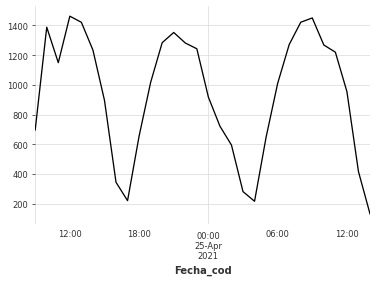

In [522]:
series_raw[0:30][col_obj].plot()

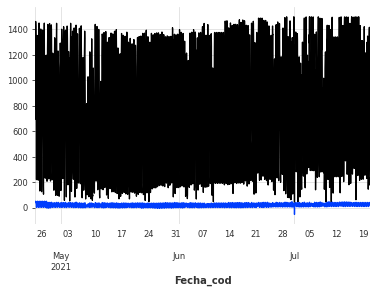

In [523]:
series_raw.plot()

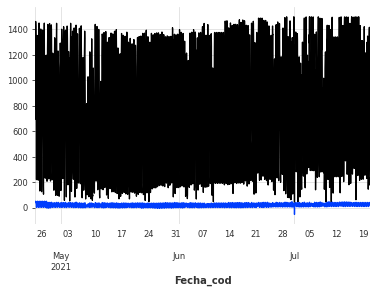

In [524]:
# TODO
filler = MissingValuesFiller()
series = filler.transform(series_raw, method='linear')
series.plot()

In [525]:
(series.values() != series_raw.values()).sum()

0

In [526]:
# len(series)

In [527]:
# new_data = pd.DataFrame(series.values(), columns=df_columns)
# new_data

In [528]:
# df[df_columns] = new_data
# df.head()

In [529]:
df.isna().sum()

index             0
Fecha             0
Tamb           2098
Tmod              0
Irradiancia    2098
Vdc               0
Idc               0
Paparente         0
Pac               0
Pdc               0
Fecha_cod         0
dtype: int64

## Predicción CNN

In [531]:
model_path

'saved_models/1dcnn_Chachapoyas_to_Juliaca_PERC'

In [532]:
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,611
Non-trainable params: 320
_________________________________________________________________


In [533]:
df_f = df.set_index('Fecha')
print_df(df_f)

(2098, 10)


,index,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
Fecha,,,,,,,,,,
2021-04-24 09:00:00,0,NaN,40.497167,NaN,168.688167,7.573600,1225.683333,696.25,1275.976130,2021-04-24 09:00:00
2021-04-24 10:00:00,1,NaN,40.059667,NaN,167.365778,8.069064,1291.077778,1387.75,1350.538889,2021-04-24 10:00:00
2021-04-24 11:00:00,2,NaN,45.897333,NaN,167.806583,8.491028,1363.922222,1149.00,1426.380556,2021-04-24 11:00:00
2021-04-24 12:00:00,3,NaN,50.813667,NaN,168.334324,7.464297,1208.514198,1462.00,1266.764674,2021-04-24 12:00:00
2021-04-24 13:00:00,4,NaN,45.737241,NaN,167.121979,6.946930,1111.436476,1420.75,1162.694625,2021-04-24 13:00:00


In [534]:
df_f["2021-04-24"][df_columns].values

array([[ 696.25      ,   40.49716667],
       [1387.75      ,   40.05966667],
       [1149.        ,   45.89733333],
       [1462.        ,   50.81366667],
       [1420.75      ,   45.73724138],
       [1234.        ,   44.03833333],
       [ 896.        ,   35.62728814],
       [ 343.75      ,   20.45216667]])

In [535]:
fecha_ini = '2021-04-25'

In [536]:
df_t = df_f[fecha_ini: fecha_fin][df_columns]
df_t['Fecha'] = df_t.index
df_t['Date'] = df_t.index.date
df_t

,Pac,Tmod,Fecha,Date
Fecha,,,,
2021-04-25 06:00:00,220.105263,2.292203,2021-04-25 06:00:00,2021-04-25
2021-04-25 07:00:00,655.000000,18.341695,2021-04-25 07:00:00,2021-04-25
2021-04-25 08:00:00,1016.450000,27.616949,2021-04-25 08:00:00,2021-04-25
2021-04-25 09:00:00,1283.750000,40.497167,2021-04-25 09:00:00,2021-04-25
2021-04-25 10:00:00,1352.283333,40.059667,2021-04-25 10:00:00,2021-04-25
...,...,...,...,...
2021-10-31 12:00:00,1416.250000,40.932926,2021-10-31 12:00:00,2021-10-31
2021-10-31 13:00:00,738.500000,36.109214,2021-10-31 13:00:00,2021-10-31
2021-10-31 14:00:00,362.250000,29.766405,2021-10-31 14:00:00,2021-10-31


In [537]:
# df_t[df_columns]

In [538]:
series_t = None
for dtime in list(df_t.Date.drop_duplicates())[:-1]:
#     print(dtime)
    x_input = df_t[str(dtime)][df_columns].values.reshape((1,11,2)) 
    pred = new_model.predict(x_input)
    if series_t is None:
        print(pred)
        series_t = pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index)
    else :
        series_t = series_t.append(pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index))
series_t

[[390.93515 612.8435  742.6521  849.40344 897.8121  887.31824 857.9257
  812.0667  765.8672  698.8566  598.1348 ]]


Fecha
2021-04-26 06:00:00    390.935150
2021-04-26 07:00:00    612.843506
2021-04-26 08:00:00    742.652100
2021-04-26 09:00:00    849.403442
2021-04-26 10:00:00    897.812073
                          ...    
2021-10-31 12:00:00    465.853973
2021-10-31 13:00:00    404.131348
2021-10-31 14:00:00    282.737549
2021-10-31 15:00:00    253.282196
2021-10-31 16:00:00    222.679199
Length: 2079, dtype: float32

In [539]:
df_t['pred']= series_t

In [541]:
image_dir =  f'graficos/{model_path.split("/")[-1]}'
image_dir

'graficos/1dcnn_Chachapoyas_to_Juliaca_PERC'

In [542]:
!mkdir graficos

mkdir: cannot create directory ‘graficos’: File exists


In [543]:
!mkdir {image_dir}

In [544]:
%%time
ls = []
for dtime in list(df_t.Date.drop_duplicates())[4:]:
    
    #previous day fig
#     print(dtime)
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
    pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name = f'graficos/{model_path.split("/")[-1]}/{model_path.split("/")[-1]}-{str(dtime)}.png'
    plt.savefig(name,bbox_inches='tight')
#     plt.savefig('images/p3.png',bbox_inches='tight')
    plt.clf()
    
    #current day fig
    
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
#     pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name_current_day = f'graficos/{model_path.split("/")[-1]}/current_day_{model_path.split("/")[-1]}-{str(dtime)}.png'
    
    plt.savefig(name_current_day,bbox_inches='tight')
    plt.clf()

    ls.append((str(dtime), name, name_current_day,\
               math.sqrt(mean_squared_error(pac, pred)),\
               math.sqrt(mean_squared_error(pac_1, pred_1))))
#     break
print(ls[:2])
len(ls)


[('2021-04-29', 'graficos/1dcnn_Chachapoyas_to_Juliaca_PERC/1dcnn_Chachapoyas_to_Juliaca_PERC-2021-04-29.png', 'graficos/1dcnn_Chachapoyas_to_Juliaca_PERC/current_day_1dcnn_Chachapoyas_to_Juliaca_PERC-2021-04-29.png', 157.76670317909412, 449.044189181236), ('2021-04-30', 'graficos/1dcnn_Chachapoyas_to_Juliaca_PERC/1dcnn_Chachapoyas_to_Juliaca_PERC-2021-04-30.png', 'graficos/1dcnn_Chachapoyas_to_Juliaca_PERC/current_day_1dcnn_Chachapoyas_to_Juliaca_PERC-2021-04-30.png', 339.3607856572571, 157.76670317909412)]
CPU times: user 1min 28s, sys: 0 ns, total: 1min 28s
Wall time: 1min 28s


186

<Figure size 432x288 with 0 Axes>

In [545]:
# list(df_t.Date.drop_duplicates())[1:-1]

In [546]:
# ls

In [547]:
ml_model_id = 10
metric_name = 'RMSE'
date = ''
value = ''
previous_value = ''
imag_path = ''

In [548]:
"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ('f', 'f', 'f', 'f', 'f', 'f','f');
"""

"\nINSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)\nVALUES ('f', 'f', 'f', 'f', 'f', 'f','f');\n"

In [549]:
stri = ''
for l in ls:
    date = l[0]
    imag_path=l[1]
    current_img_path = l[2]
    value=l[3]
    previous_value=l[4]
    stri +=f"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ({ml_model_id}, '{metric_name}', '{date}', {value}, {previous_value}, '{imag_path}','{current_img_path}');
"""

In [550]:
len(stri.split('\n\n'))

186

In [551]:
stri_cachatojuliaca_cnn_PERC = stri

In [552]:
#Imprimir comando INSERT INTO
# 
print(stri_cachatojuliaca_cnn_PERC)




INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES (10, 'RMSE', '2021-04-29', 157.76670317909412, 449.044189181236, 'graficos/1dcnn_Chachapoyas_to_Juliaca_PERC/1dcnn_Chachapoyas_to_Juliaca_PERC-2021-04-29.png','graficos/1dcnn_Chachapoyas_to_Juliaca_PERC/current_day_1dcnn_Chachapoyas_to_Juliaca_PERC-2021-04-29.png');

INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES (10, 'RMSE', '2021-04-30', 339.3607856572571, 157.76670317909412, 'graficos/1dcnn_Chachapoyas_to_Juliaca_PERC/1dcnn_Chachapoyas_to_Juliaca_PERC-2021-04-30.png','graficos/1dcnn_Chachapoyas_to_Juliaca_PERC/current_day_1dcnn_Chachapoyas_to_Juliaca_PERC-2021-04-30.png');

INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALU

## Datos PERC Not Transfered

In [553]:
!ls {data_path}

llenado_Arequipa_UNSA_CIGS_agg_day_hour.csv
llenado_Arequipa_UNSA_HIT_agg_day_hour.csv
llenado_Arequipa_UNSA_PERC_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_CIGS_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_HIT_agg_day_hour.csv
llenado_Chachapoyas_UNTRM_PERC_agg_day_hour.csv
llenado_Juliaca_UNAJ_CIGS_agg_day_hour.csv
llenado_Juliaca_UNAJ_HIT_agg_day_hour.csv
llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv
llenado_Lima_PUCP_CIGS_agg_day_hour.csv
llenado_Lima_PUCP_HIT_agg_day_hour.csv
llenado_Lima_PUCP_PERC_agg_day_hour.csv
llenado_Tacna_UNJBG_CIGS_agg_day_hour.csv
llenado_Tacna_UNJBG_HIT_agg_day_hour.csv
llenado_Tacna_UNJBG_PERC_agg_day_hour.csv


### Lectura de datos

In [554]:
data_file = data_path+'llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv'
model_path = 'saved_models/1dcnn_Juliaca_PERC'
model = '1dcnn'
technology = 'PERC'
ubicacion = 'Juliaca'
df_columns = ['Pac', 'Tmod']
fecha_ini = '2021-02-01'
fecha_fin = '2021-10-31'

In [555]:
data_file

'/data/dibanez/tesis/data_preprocesada/2.llenada/llenado_Juliaca_UNAJ_PERC_agg_day_hour.csv'

In [556]:
df = pd.read_csv(data_file, parse_dates=True)
df.Fecha = pd.to_datetime(df.Fecha)
df=df.reset_index()
print_df(df)

(2098, 10)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc
0,0,2021-04-24 09:00:00,NaN,40.497167,NaN,168.688167,7.573600,1225.683333,696.25,1275.976130
1,1,2021-04-24 10:00:00,NaN,40.059667,NaN,167.365778,8.069064,1291.077778,1387.75,1350.538889
2,2,2021-04-24 11:00:00,NaN,45.897333,NaN,167.806583,8.491028,1363.922222,1149.00,1426.380556
3,3,2021-04-24 12:00:00,NaN,50.813667,NaN,168.334324,7.464297,1208.514198,1462.00,1266.764674
4,4,2021-04-24 13:00:00,NaN,45.737241,NaN,167.121979,6.946930,1111.436476,1420.75,1162.694625


In [557]:
print(df.Fecha.min())
print(df.Fecha.max())

2021-04-24 09:00:00
2021-10-31 16:00:00


In [558]:
df.isna().sum()/len(df)

index          0.0
Fecha          0.0
Tamb           1.0
Tmod           0.0
Irradiancia    1.0
Vdc            0.0
Idc            0.0
Paparente      0.0
Pac            0.0
Pdc            0.0
dtype: float64

### Preprocesamiento

In [559]:
start = df.iloc[0]['Fecha']

In [560]:
df['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df))
# df.head(13)

In [561]:
series_raw = TimeSeries.from_dataframe(df, 'Fecha_cod', df_columns)#,'Irradiancia'])#, freq='H')


In [562]:
col_obj = 'Pac'

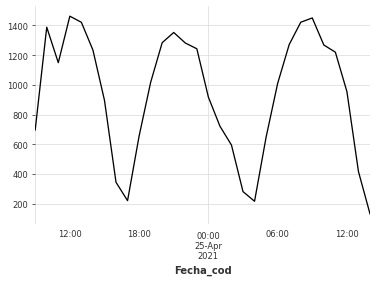

In [563]:
series_raw[0:30][col_obj].plot()

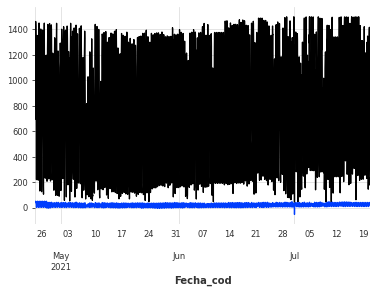

In [564]:
series_raw.plot()

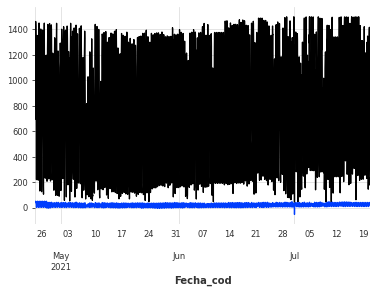

In [565]:
# TODO
filler = MissingValuesFiller()
series = filler.transform(series_raw, method='linear')
series.plot()

In [566]:
(series.values() != series_raw.values()).sum()

0

In [567]:
# len(series)

In [568]:
# new_data = pd.DataFrame(series.values(), columns=df_columns)
# new_data

In [569]:
# df[df_columns] = new_data
# df.head()

In [570]:
df.isna().sum()

index             0
Fecha             0
Tamb           2098
Tmod              0
Irradiancia    2098
Vdc               0
Idc               0
Paparente         0
Pac               0
Pdc               0
Fecha_cod         0
dtype: int64

## Predicción CNN

In [571]:
model_path

'saved_models/1dcnn_Juliaca_PERC'

In [572]:
new_model = tf.keras.models.load_model(model_path)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [573]:
df_f = df.set_index('Fecha')
print_df(df_f)

(2098, 10)


,index,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
Fecha,,,,,,,,,,
2021-04-24 09:00:00,0,NaN,40.497167,NaN,168.688167,7.573600,1225.683333,696.25,1275.976130,2021-04-24 09:00:00
2021-04-24 10:00:00,1,NaN,40.059667,NaN,167.365778,8.069064,1291.077778,1387.75,1350.538889,2021-04-24 10:00:00
2021-04-24 11:00:00,2,NaN,45.897333,NaN,167.806583,8.491028,1363.922222,1149.00,1426.380556,2021-04-24 11:00:00
2021-04-24 12:00:00,3,NaN,50.813667,NaN,168.334324,7.464297,1208.514198,1462.00,1266.764674,2021-04-24 12:00:00
2021-04-24 13:00:00,4,NaN,45.737241,NaN,167.121979,6.946930,1111.436476,1420.75,1162.694625,2021-04-24 13:00:00


In [574]:
df_f["2021-04-24"][df_columns].values

array([[ 696.25      ,   40.49716667],
       [1387.75      ,   40.05966667],
       [1149.        ,   45.89733333],
       [1462.        ,   50.81366667],
       [1420.75      ,   45.73724138],
       [1234.        ,   44.03833333],
       [ 896.        ,   35.62728814],
       [ 343.75      ,   20.45216667]])

In [575]:
fecha_ini = '2021-04-25'

In [576]:
df_t = df_f[fecha_ini: fecha_fin][df_columns]
df_t['Fecha'] = df_t.index
df_t['Date'] = df_t.index.date
df_t

,Pac,Tmod,Fecha,Date
Fecha,,,,
2021-04-25 06:00:00,220.105263,2.292203,2021-04-25 06:00:00,2021-04-25
2021-04-25 07:00:00,655.000000,18.341695,2021-04-25 07:00:00,2021-04-25
2021-04-25 08:00:00,1016.450000,27.616949,2021-04-25 08:00:00,2021-04-25
2021-04-25 09:00:00,1283.750000,40.497167,2021-04-25 09:00:00,2021-04-25
2021-04-25 10:00:00,1352.283333,40.059667,2021-04-25 10:00:00,2021-04-25
...,...,...,...,...
2021-10-31 12:00:00,1416.250000,40.932926,2021-10-31 12:00:00,2021-10-31
2021-10-31 13:00:00,738.500000,36.109214,2021-10-31 13:00:00,2021-10-31
2021-10-31 14:00:00,362.250000,29.766405,2021-10-31 14:00:00,2021-10-31


In [577]:
# df_t[df_columns]

In [578]:
series_t = None
for dtime in list(df_t.Date.drop_duplicates())[:-1]:
#     print(dtime)
    x_input = df_t[str(dtime)][df_columns].values.reshape((1,11,2)) 
    pred = new_model.predict(x_input)
    if series_t is None:
        print(pred)
        series_t = pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index)
    else :
        series_t = series_t.append(pd.Series(pred.ravel(), df_t[str(dtime+ dt.timedelta(days=1))].index))
series_t

[[219.06866 350.85773 534.771   623.63513 707.1924  709.91095 668.348
  669.5811  612.7576  478.53146 396.81577]]


Fecha
2021-04-26 06:00:00    219.068665
2021-04-26 07:00:00    350.857727
2021-04-26 08:00:00    534.770996
2021-04-26 09:00:00    623.635132
2021-04-26 10:00:00    707.192383
                          ...    
2021-10-31 12:00:00    934.012207
2021-10-31 13:00:00    798.578186
2021-10-31 14:00:00    565.235962
2021-10-31 15:00:00    215.200684
2021-10-31 16:00:00     34.837223
Length: 2079, dtype: float32

In [579]:
df_t['pred']= series_t

In [580]:
image_dir =  f'graficos/{model_path.split("/")[-1]}'
image_dir

'graficos/1dcnn_Juliaca_PERC'

In [581]:
!mkdir graficos

mkdir: cannot create directory ‘graficos’: File exists


In [582]:
!mkdir {image_dir}

In [583]:
%%time
ls = []
for dtime in list(df_t.Date.drop_duplicates())[4:]:
    
    #previous day fig
#     print(dtime)
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
    pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name = f'graficos/{model_path.split("/")[-1]}/{model_path.split("/")[-1]}-{str(dtime)}.png'
    plt.savefig(name,bbox_inches='tight')
#     plt.savefig('images/p3.png',bbox_inches='tight')
    plt.clf()
    
    #current day fig
    
    pac = df_t[str(dtime)]['Pac']
    pred = df_t[str(dtime)]['pred']
    pac_1 = df_t[str(dtime- dt.timedelta(days=1))]['Pac']
    pred_1 = df_t[str(dtime- dt.timedelta(days=1))]['pred']
    pac_2 = df_t[str(dtime- dt.timedelta(days=2))]['Pac']
    pred_2 = df_t[str(dtime- dt.timedelta(days=2))]['pred']
#     pac_3 = df_t[str(dtime- dt.timedelta(days=3))]['Pac']
#     pred_3 = df_t[str(dtime- dt.timedelta(days=3))]['pred']
    
#     pac_3.plot(color='r', marker='o', markersize=4)
#     pred_3.plot(color='g', marker='o', markersize=4)
    pac_2.plot(color='r', marker='o', markersize=4)
    pred_2.plot(color='g', marker='o', markersize=4)
    pac_1.plot(color='r', marker='o', markersize=4)
    pred_1.plot(color='g', marker='o', markersize=4)
#     pac.plot(color='r', marker='o', markersize=4)
    pred.plot(color='g', marker='o', markersize=4)
    
    plt.legend(['Pac real', 'Pac predicho'])
    plt.ylabel('Pac (W)')
    plt.xlabel('Fecha y hora')
    name_current_day = f'graficos/{model_path.split("/")[-1]}/current_day_{model_path.split("/")[-1]}-{str(dtime)}.png'
    
    plt.savefig(name_current_day,bbox_inches='tight')
    plt.clf()

    ls.append((str(dtime), name, name_current_day,\
               math.sqrt(mean_squared_error(pac, pred)),\
               math.sqrt(mean_squared_error(pac_1, pred_1))))
#     break
print(ls[:2])
len(ls)


[('2021-04-29', 'graficos/1dcnn_Juliaca_PERC/1dcnn_Juliaca_PERC-2021-04-29.png', 'graficos/1dcnn_Juliaca_PERC/current_day_1dcnn_Juliaca_PERC-2021-04-29.png', 132.9577639529364, 496.08675906893643), ('2021-04-30', 'graficos/1dcnn_Juliaca_PERC/1dcnn_Juliaca_PERC-2021-04-30.png', 'graficos/1dcnn_Juliaca_PERC/current_day_1dcnn_Juliaca_PERC-2021-04-30.png', 166.60863463470454, 132.9577639529364)]
CPU times: user 1min 29s, sys: 0 ns, total: 1min 29s
Wall time: 1min 28s


186

<Figure size 432x288 with 0 Axes>

In [584]:
# list(df_t.Date.drop_duplicates())[1:-1]

In [585]:
# ls

In [586]:
ml_model_id = 9
metric_name = 'RMSE'
date = ''
value = ''
previous_value = ''
imag_path = ''

In [587]:
"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ('f', 'f', 'f', 'f', 'f', 'f','f');
"""

"\nINSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)\nVALUES ('f', 'f', 'f', 'f', 'f', 'f','f');\n"

In [588]:
stri = ''
for l in ls:
    date = l[0]
    imag_path=l[1]
    current_img_path = l[2]
    value=l[3]
    previous_value=l[4]
    stri +=f"""
INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES ({ml_model_id}, '{metric_name}', '{date}', {value}, {previous_value}, '{imag_path}','{current_img_path}');
"""

In [589]:
len(stri.split('\n\n'))

186

In [590]:
stri_cachatojuliaca_cnn_PERC = stri

In [591]:
#Imprimir comando INSERT INTO
# 
print(stri_cachatojuliaca_cnn_PERC)




INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES (9, 'RMSE', '2021-04-29', 132.9577639529364, 496.08675906893643, 'graficos/1dcnn_Juliaca_PERC/1dcnn_Juliaca_PERC-2021-04-29.png','graficos/1dcnn_Juliaca_PERC/current_day_1dcnn_Juliaca_PERC-2021-04-29.png');

INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES (9, 'RMSE', '2021-04-30', 166.60863463470454, 132.9577639529364, 'graficos/1dcnn_Juliaca_PERC/1dcnn_Juliaca_PERC-2021-04-30.png','graficos/1dcnn_Juliaca_PERC/current_day_1dcnn_Juliaca_PERC-2021-04-30.png');

INSERT INTO `DBTesis`.`metrics` (`ml_model_id`, `metric_name`, `date`, `value`, `previous_value`, `metric_image_path`, `metric_current_image_path`)
VALUES (9, 'RMSE', '2021-05-01', 247.47882823287375, 166.60863463470454, 'graficos/1dcnn_Juliaca_PERC/1dcnn_Juliaca_PERC-2021

In [593]:
# !zip -r graficos13469-10.zip graficos